In this short tutorial we will install and use [MARTINI](https://martini.readthedocs.io/en/latest/), an analysis package for creating mock HI-data cubes similar to radio interferometer data, written by Kyle Oman (kyle.a.oman@durham.ac.uk). This example uses the input from the [IllustrisTNG](https://ui.adsabs.harvard.edu/abs/2018MNRAS.473.4077P/abstract) simulations. The data are publicly available and hosted at [tng-project.org](https://www.tng-project.org/).

This tutorial can be run either on the [TNG JupyterLab environment](https://www.tng-project.org/data/lab/), or on any system with internet access.

![MARTINI](https://github.com/kyleaoman/martini/raw/main/martini_banner.png)

MARTINI is a modular package for the creation of synthetic resolved HI line observations (data cubes) of smoothed-particle hydrodynamics simulations of galaxies. The various aspects of the mock-observing process are divided logically into sub-modules handling the data cube, source, beam, noise, spectral model and SPH kernel. MARTINI is object-oriented: each sub-module provides a class (or classes) which can be configured as desired. For most sub-modules, base classes are provided to allow for straightforward customization. Instances of each sub-module class are given as parameters to the Martini class; a mock observation is then constructed by calling a handful of functions to execute the desired steps in the mock-observing process.

This tutorial focuses on particulars related to working with the IllustrisTNG simulations. More general information is available in the MARTINI documentation, [hosted on ReadTheDocs](https://martini.readthedocs.io/en/latest/).

## Installation

MARTINI requires `python3` version `3.9` or higher.

The following command will use `pip` to download and install [MARTINI from pypi](https://pypi.org/project/astromartini/):

In [1]:
import sys

!{sys.executable} -m pip install "astromartini[tngsource]==2.1.6"

If you do not have superuser permissions or use a virtual environment, you may wish to add the --user flag.
With this command required dependencies will be fetched and installed automatically. Watch for error messages during installation. For greater control you may also install the dependencies by hand. These are: numpy, astropy, scipy, h5py, six and requests.

We'll also install matplotlib, used in this notebook:

In [2]:
!{sys.executable} -m pip install matplotlib

This cell may be needed in some cases to display figures below:

In [3]:
%matplotlib inline

Let's check that we can `import martini`:

In [4]:
import martini

If this produces errors, you may need to restart the Python kernel of this notebook so that it sees the recently installed packages (Kernel -> Restart in the menubar).

We can run MARTINI's built-in demo to check that all of the basic functionality works:

In [5]:
from martini import demo

demo()

Source module contained 500 particles with total HI mass of 5.00e+09 solMass.
Pruned particles that will not contribute to data cube, 500 particles remaining with total HI mass of 5.00e+09 solMass.


100%|██████████| 23716/23716 [00:28<00:00, 837.84it/s] 


Source inserted.
  Flux density in cube: 2.34e+02 Jy
  Mass in cube (assuming distance 3.00 Mpc and a spatially resolved source): 4.96e+09 solMass
    [99% of initial source mass]
  Maximum pixel: 1.13e-03 Jy / arcsec2
  Median non-zero pixel: 6.97e-10 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-07 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 2.46e-05 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 2.85e-02 Jy / beam
  Maximum pixel: 6.58e-01 Jy / beam
  Median non-zero pixel: 3.30e-05 Jy / beam
Wrote demo fits output to testcube.fits, and beam image to testbeam.fits.
Wrote demo hdf5 output to testcube.hdf5.


When run successfully, this will make a mock observation of a very simple analytic disc model and write some output to the working directory. Rather than inspect this toy model, let's look at a "real" simulation...

## TNG Data

The `TNGSource` module in MARTINI is designed to run on the IllustrisTNG [JupyterLab](https://www.tng-project.org/data/lab/), or in a standalone mode. If you are running on the TNG JupyterLab then the simulations are stored locally on disk and will be detected and used. Otherwise, the `TNGSource` module will use the TNG [web API](https://www.tng-project.org/data/docs/api/) to download the particles for the galaxy of interest. If running in standalone mode, an API key for the TNG web API is required. You must first [register](https://www.tng-project.org/users/register/) for an account. Once you are registered, your API key can be found [here](https://www.tng-project.org/users/profile/). Enter your API key using the following cell (if you are running this notebook on the TNG JupyterLab, you may leave it blank):

In [6]:
from getpass import getpass

api_key = getpass("TNG web API key:")

TNG web API key: ········


We can choose a galaxy of interest by selection a [simulation](https://www.tng-project.org/data/docs/background/), a [snapshot](http://www.tng-project.org/data/docs/specifications/#sec1a) and a subhalo ID. One way to search for a subhalo ID is to use [this tool](https://www.tng-project.org/data/search/) - the `ID` column in search results contains subhalo IDs. For example:

In [7]:
simulation = "TNG100-1"
snapshot = 99
subhalo_id = 400547  # a central subhalo with 218 < Vmax < 220, and SFR > 1

## TNG Example

First, import some modules from MARTINI, and the units module from astropy.

In [8]:
import numpy as np
from martini.sources import TNGSource
from martini import DataCube, Martini
from martini.beams import GaussianBeam
from martini.noise import GaussianNoise
from martini.spectral_models import GaussianSpectrum
from martini.sph_kernels import CubicSplineKernel
import astropy.units as U

The different martini sub-modules need to be initialized, see the [full documentation](https://kyleaoman.github.io/martini/build/html/) for details of all configuration options. A few suggested best-practices specific to TNG are outlined below.

### SOURCE

Notice that your API key must be provided unless you are using `TNGSource` on the TNG JupyterLab (if you provide it anyways in that case, it will simply be ignored).

Any downloaded data can be cached using the `cutout_dir` parameter to specify a directory, if a cache for the requested galaxy is found it will be used instead of re-downloading the data. If running on the TNG JupyterLab environment, this parameter is ignored.

In [9]:
source = TNGSource(
    simulation,
    snapshot,
    subhalo_id,
    api_key=api_key,
    cutout_dir=".",
    distance=4 * U.Mpc,
    rotation={"rotmat": np.eye(3)},
    ra=0.0 * U.deg,
    dec=0.0 * U.deg,
)

Using local cutout file martini-cutout-TNG100-1-99-517.hdf5


The rotation argument above has been set to the identity matrix, so the source has the (random) orientation that it has within the simulation volume. The source class includes a function to make a quick plot to get an idea of the source's appearance:

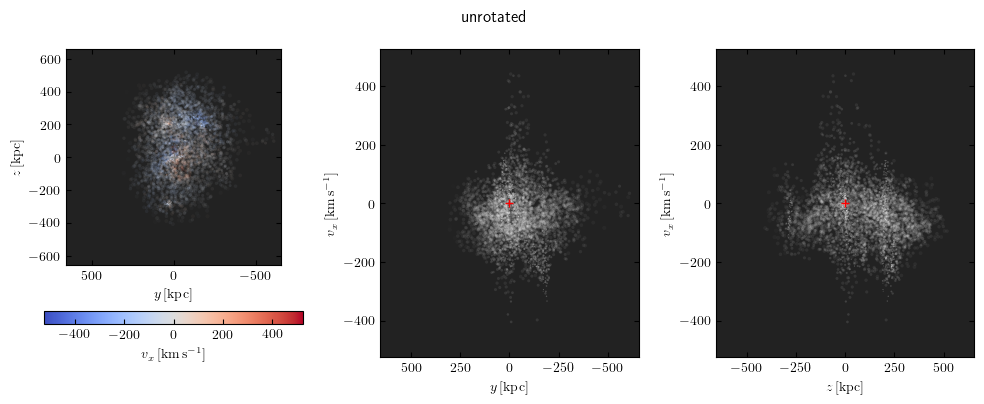

In [10]:
preview_fig_unrotated = source.preview(title="unrotated")

The preview function defaults to apertures in position and velocity that enclose all particles in the source, so this preview emphasizes the diffuse circumgalactic gas. The apertures can be set manually using the `lim` and `vlim` keywords to set the maximum absolute offsets in position and velocity relative to the source centre to be plotted. For example, restricting the aperture to 50kpc and 300km/s makes the disc more clearly visible.

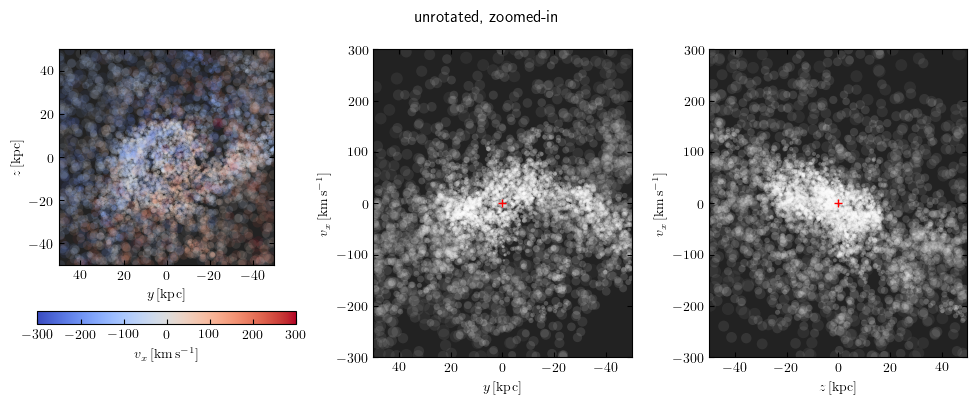

In [11]:
preview_fig_unrotated_zoom = source.preview(
    title="unrotated, zoomed-in",
    lim=50 * U.kpc,
    vlim=300 * U.km / U.s,
)

This randomly-oriented viewing angle seems to be close to face-on. The source can be rotated to a different orientation. MARTINI's tool for quick/approximate manipulation of the orientation of the source aligns the source based on its angular momentum vector ("L"), for example:

In [12]:
source.rotate(L_coords=(60 * U.deg, 90 * U.deg))

The rotation configuration takes an inclination (here 60deg) and rotation about the pole (here 90deg, relative to an arbitrary reference direction). The code attempts to
automatically align the galactic disk in the y-z plane by aligning
the angular momentum along the x-axis. The polar rotation is then
applied, and finally the disc inclined by a rotation around the
y-axis (the line of sight is along the x-axis). The automatic
alignment will work for typical reasonably isolated discs, but will
struggle when companions are present, when the angular momentum axis
is a poor tracer of the disc plane, and especially for satellites.

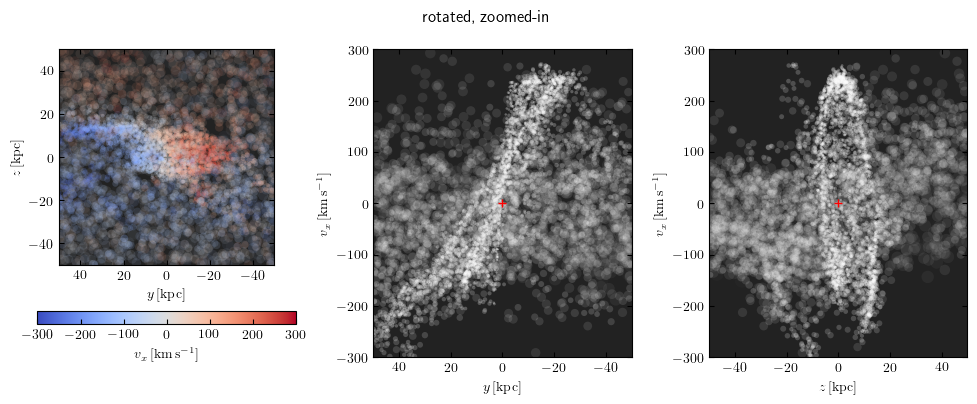

In [13]:
preview_fig_rotated_zoomed_in = source.preview(
    title="rotated, zoomed-in",
    lim=50 * U.kpc,
    vlim=300 * U.km / U.s,
)

If finer control of the orientation is needed, derive the transformation from the simulation box coordinates (see [the documentation](https://martini.readthedocs.io/en/latest/) for examples) to the desired coordinates for the 'observation', keeping in mind that the line of sight is along the x-axis. This rotation matrix can then be passed to the rotate function as `rotmat=np.eye(3)` (here the identity rotation matrix used as a place holder). The rotation can also be provided when the source is initialized by using the `rotation` keyword argument.

A common problem is deriving the inverse transform instead of the forward transform, if unexpected results are obtained, first try passing the transpose of the rotation matrix.

### DATACUBE

It is usually advisable to set the centre of the cube to track the
centre of the source, as illustrated below. Note that the source
systemic velocity is set according to the distance, peculiar velocity, and Hubble's law.
These values can instead be set explicitly, if desired. A datacube
with 128x128 pixels usually takes a few minutes, depending on the number of particles. 1024x1024 can take
several hours. The number of channels has less influence on the
runtime. Most of the runtime is spent when `M.insert_source_in_cube` is
called below.

In [14]:
datacube = DataCube(
    n_px_x=384,
    n_px_y=384,
    n_channels=50,
    px_size=10.0 * U.arcsec,
    channel_width=16.0 * U.km * U.s**-1,
    velocity_centre=source.vsys,
    ra=source.ra,
    dec=source.dec,
)

### BEAM

It is usually advisable to set the beam size to be ~3x the pixel
size. Note that the data cube is padded according to the size of the
beam, this usually results in the number of pixel rows printed in the
progress messages to differ from the requested dimensions. The
padding is required for accurate convolution with the beam, but
contains incorrect values after convolution and is discarded to
produce the final data cube of the requested size.

In [15]:
beam = GaussianBeam(
    bmaj=30.0 * U.arcsec, bmin=30.0 * U.arcsec, bpa=0.0 * U.deg, truncate=3.0
)

### NOISE

The noise is normally added before convolution with the beam (as
below in this example). The rms value passed is that corresponding to the desired noise level in the final data cube, in Jy/beam or equivalent units. To obtain consistent random realisations each time the code is run, we provide a random seed (integer).

In [16]:
noise = GaussianNoise(
    rms=3.0e-8 * U.Jy * U.beam**-1,
    seed=0,
)

### SPECTRAL MODEL

The `thermal` mode estimates the HI line width for each particle based on its properties (temperature, etc.). The 'subgrid' velocity dispersion can also be fixed to a constant value, e.g. `sigma=7 * U.km / U.s`.

In [17]:
spectral_model = GaussianSpectrum(sigma="thermal")

The calculation of the spectra (that will happen when the `Martini` module is initialized below) can be done in parallel by providing a keyword argument `ncpu=N`, where `N` is the number of CPUs to use. However, the details of the implementation mean that for small numbers of particles running in parallel tends to slow down the calculation, so turning this on should be done with care. Significant speedups can be expected when the particle count is very large.

### SPH KERNEL

Since IllustrisTNG uses a moving mesh hydrodynamics solver (Arepo),
there are no formal SPH smoothing lengths and no specified kernel.
However, approximate smoothing lengths can be derived from the cell
volumes and densities, so a reasonable approximation is to use these for imaging. The `TNGSource` module has already computed equivalent SPH smoothing lengths in the correct format for MARTINI, so we just need to choose a smoothing kernel. The `CubicSplineKernel` is perfectly fine here.

In [18]:
sph_kernel = CubicSplineKernel()

### MARTINI

Now set up the configuration:

In [19]:
M = Martini(
    source=source,
    datacube=datacube,
    beam=beam,
    noise=noise,
    spectral_model=spectral_model,
    sph_kernel=sph_kernel,
)

Source module contained 259173 particles with total HI mass of 3.47e+10 solMass.
Pruned particles that will not contribute to data cube, 36038 particles remaining with total HI mass of 1.90e+10 solMass.


Similar to previewing the source, we can make a preview here. Now the extent of the datacube is overlaid with a red box.

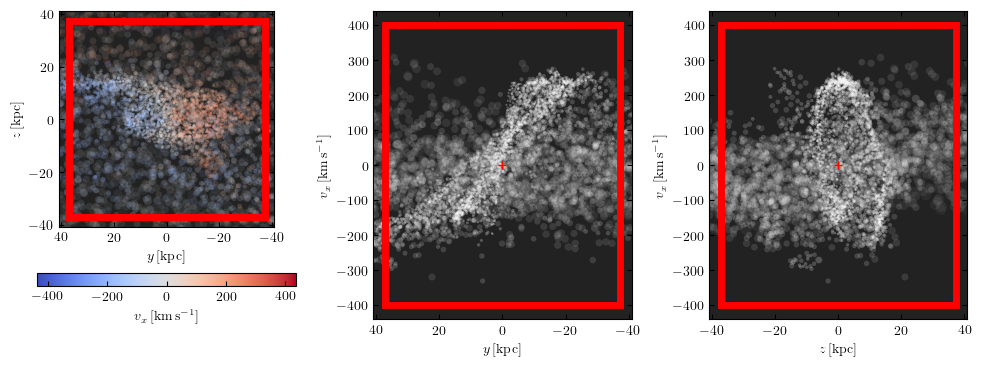

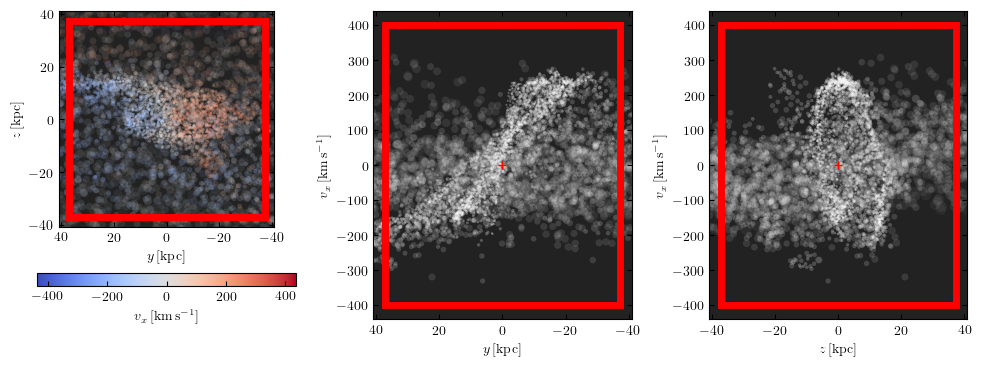

In [20]:
M.preview()

The main source insertion loop, that is the most computationally demanding step, can be run in parallel if the `multiprocess` package is installed (not to be confused with `multiprocessing`, which is normally included with python!). Edit the cell below to use more than 1 CPU core if this package is installed.

In [21]:
ncpu = 1  # can be >1 if multiprocess package is installed

If we're happy with the preview, we're ready to call the functions to make the actual mock observation.

In [22]:
M.insert_source_in_cube(ncpu=ncpu)
M.add_noise()
M.convolve_beam()

100%|██████████| 163216/163216 [09:51<00:00, 275.74it/s]


Source inserted.
  Flux density in cube: 3.05e+02 Jy
  Mass in cube (assuming distance 4.00 Mpc and a spatially resolved source): 1.84e+10 solMass
    [53% of initial source mass]
  Maximum pixel: 1.25e-04 Jy / arcsec2
  Median non-zero pixel: 5.83e-14 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 2.87e-06 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 2.99e-03 Jy / beam
  Maximum pixel: 1.14e-01 Jy / beam
  Median non-zero pixel: 3.56e-08 Jy / beam


You may notice that the number of pixels in the progress counter differs from the number defined in the DataCube module. This is because convolution with the beam requires some padding, which is ultimately filled with nonsense and discarded.

To write the results: two output formats are available, depending on preference. Both
formats are self-documenting, via FITS header keywords and HDF5
attributes, respectively. For HDF5 output, the beam image is included
in the same file. (If you do not have h5py installed, comment out the call to `write_hdf5`.)

In [23]:
M.write_fits("tng_martini_demo.fits")
M.write_beam_fits("tng_martini_demo_beam.fits")
M.write_hdf5("tng_martini_demo.hdf5")

### Inspect the results (FITS)

Let's load the FITS file that MARTINI produced and take a quick look.

In [24]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS

with fits.open("tng_martini_demo.fits") as f:
    cube_wcs = WCS(f[0].header)
    flux_cube = f[0].data * U.Unit(f[0].header["BUNIT"])
    n_channels = cube_wcs.pixel_shape[cube_wcs.wcs.spec]
    vch = np.array(cube_wcs.sub(axes=[3]).all_pix2world(np.arange(n_channels), 0))[
        0
    ] * U.Unit(cube_wcs.world_axis_units[cube_wcs.wcs.spec])
    vch = vch - source.vsys

In [25]:
flux_cube.shape

(50, 384, 384)

Let's examine one of the velocity channels:

In [26]:
import matplotlib.pyplot as plt

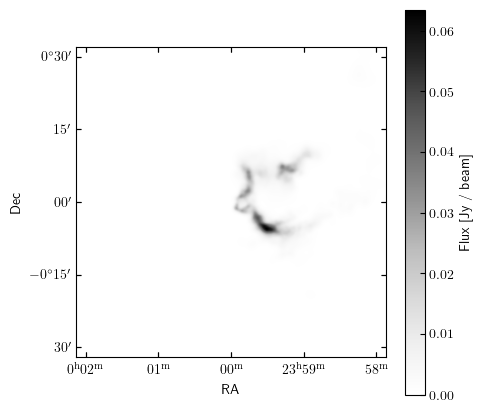

In [27]:
fig = plt.figure(figsize=(5, 5))
plt.clf()
ax = fig.add_subplot(1, 1, 1, aspect="equal", projection=cube_wcs.celestial)

# choose units for plotting, not necessarily the units data are stored in:
flux_unit = U.Jy / U.beam

plt.imshow(flux_cube[15, ...].to_value(flux_unit), cmap="Greys")
plt.xlabel("RA")
plt.ylabel("Dec")
plt.colorbar(label=f"Flux [{flux_unit}]");

And do a quick plot of the first three moments:

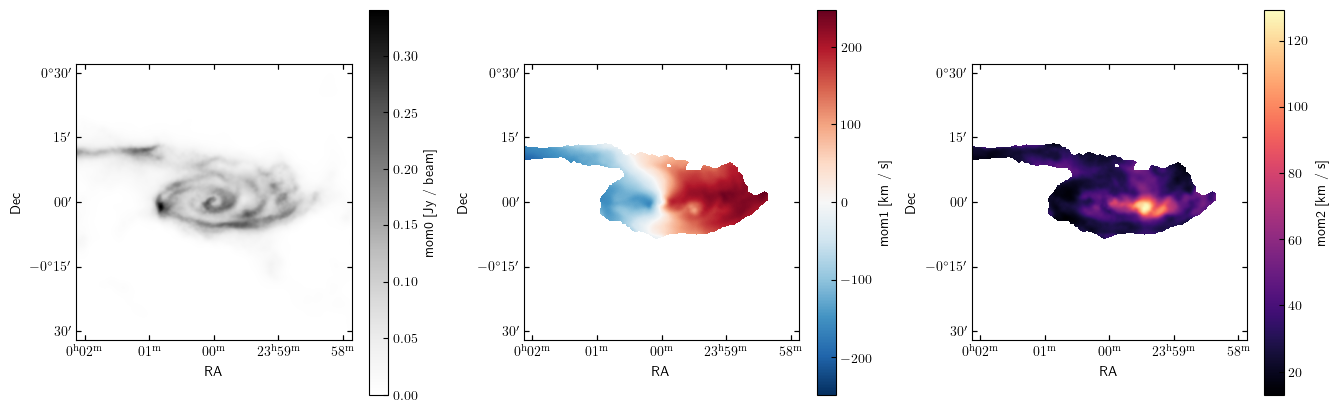

In [28]:
import numpy as np

# choose plotting units
mom0_unit = U.Jy / U.beam
mom1_unit = U.km / U.s
mom2_unit = U.km / U.s

rms = np.std(
    flux_cube[:, :16, :16]
)  # noise in a corner patch where there is little signal
clip = np.where(flux_cube > 5 * rms, 1, 0)
np.seterr(all="ignore")
fig = plt.figure(figsize=(16, 5))
plt.clf()
sp1 = fig.add_subplot(1, 3, 1, aspect="equal", projection=cube_wcs.celestial)
sp2 = fig.add_subplot(1, 3, 2, aspect="equal", projection=cube_wcs.celestial)
sp3 = fig.add_subplot(1, 3, 3, aspect="equal", projection=cube_wcs.celestial)
mom0 = np.sum(flux_cube, axis=0)
mask = np.where(mom0 > 0.05 * U.Jy / U.beam, 1, np.nan)
mom1 = np.sum(flux_cube * clip * vch[:, np.newaxis, np.newaxis], axis=0) / mom0
mom2 = np.sqrt(
    np.sum(
        flux_cube
        * clip
        * np.power(vch[:, np.newaxis, np.newaxis] - mom1[np.newaxis], 2),
        axis=0,
    )
    / mom0
)
im1 = sp1.imshow(mom0.to_value(mom0_unit), cmap="Greys")
plt.colorbar(im1, ax=sp1, label=f"mom0 [{mom0_unit}]")
im2 = sp2.imshow(
    (mom1 * mask).to_value(mom1_unit),
    cmap="RdBu_r",
    vmin=-np.nanmax(np.abs(mom1 * mask)).to_value(mom1_unit),
    vmax=np.nanmax(np.abs(mom1 * mask)).to_value(mom1_unit),
)
plt.colorbar(im2, ax=sp2, label=f"mom1 [{mom1_unit}]")
im3 = sp3.imshow(
    (mom2 * mask).to_value(mom2_unit),
    cmap="magma",
)
plt.colorbar(im3, ax=sp3, label=f"mom2 [{mom2_unit}]")
for sp in sp1, sp2, sp3:
    sp.set_xlabel("RA")
    sp.set_ylabel("Dec")

plt.subplots_adjust(wspace=0.3)

This galaxy clearly has a very nice spiral morphology in HI, has a rotation-dominated velocity field, and is interacting with a companion. The alignment of the disc looks as expected - the inclination looks to be about 60 degrees, and the position angle is horizontal in the figure - in this case the automated orientation function has performed well, though it should never be assumed that this will always be the case!

For complete documentation, more usage examples, and further information, please take a look at the [MARTINI webpage](https://kyleaoman.github.io/martini).

### Inspect the results (HDF5)

Let's load the HDF5 that MARTINI produced and take a quick look.

In [29]:
import h5py

f = h5py.File("tng_martini_demo.hdf5", "r")

In [30]:
list(f.keys())

['Beam',
 'Dec',
 'Dec_vertices',
 'FluxCube',
 'RA',
 'RA_vertices',
 'channel_mids',
 'channel_vertices',
 'frequency_channel_edges',
 'frequency_channel_mids',
 'velocity_channel_edges',
 'velocity_channel_mids']

In addition to the mock cube itself (`f["FluxCube"]`), the HDF5 output contains arrays of the same size with the coordinates of the centre of each cell in the cube in RA, Dec and spectral space (`f["RA"]`,`f["Dec"]` and `f["channel_mids"]`). There are also arrays longer by one in each dimension that contain the coordinates of the corners of each cell in the cube (`f["RA_vertices"]`,`f["Dec_vertices"]` and `f["channel_vertices"]`). The latter are convenient for use with the `pcolormesh` plotting function from matplotlib, so we'll read these.

In [31]:
flux_cube = f["FluxCube"][()] * U.Unit(f["FluxCube"].attrs["FluxCubeUnit"])
ra_vertices = f["RA_vertices"][()] * U.Unit(f["RA_vertices"].attrs["Unit"])
dec_vertices = f["Dec_vertices"][()] * U.Unit(f["RA_vertices"].attrs["Unit"])
spec_vertices = f["channel_vertices"][()] * U.Unit(f["channel_vertices"].attrs["Unit"])
vch = (
    f["velocity_channel_mids"][()] * U.Unit(f["velocity_channel_mids"].attrs["Unit"])
    - source.vsys
)
f.close()

The RA range of our cube straddles the RA=0 boundary, let's shift the `ra_vertices` to a (-180, 180] range for plotting:

In [32]:
ra_vertices = np.where(
    ra_vertices > 180 * U.deg, ra_vertices - 360 * U.deg, ra_vertices
)

In [33]:
flux_cube.shape

(384, 384, 50)

Let's examine one of the velocity channels:

In [34]:
import matplotlib.pyplot as plt

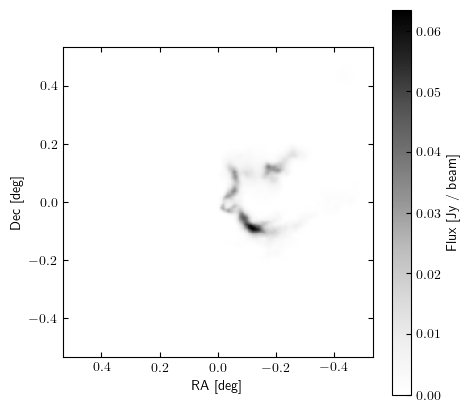

In [35]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

channel_slice = np.s_[:, :, 15]  # a slice of the data cube containing one channel

# choose units for plotting, not necessarily the units data are stored in:
ra_unit = U.deg
dec_unit = U.deg
flux_unit = U.Jy / U.beam

plt.pcolormesh(
    ra_vertices[channel_slice].to_value(ra_unit),
    dec_vertices[channel_slice].to_value(dec_unit),
    flux_cube[channel_slice].to_value(flux_unit),
    cmap="Greys",
)
ax.set_xlabel(f"RA [{ra_unit}]")
ax.set_ylabel(f"Dec [{dec_unit}]")
ax.set_xlim(ax.get_xlim()[::-1])
plt.colorbar(label=f"Flux [{flux_unit}]");

And do a quick plot of the first three moments:

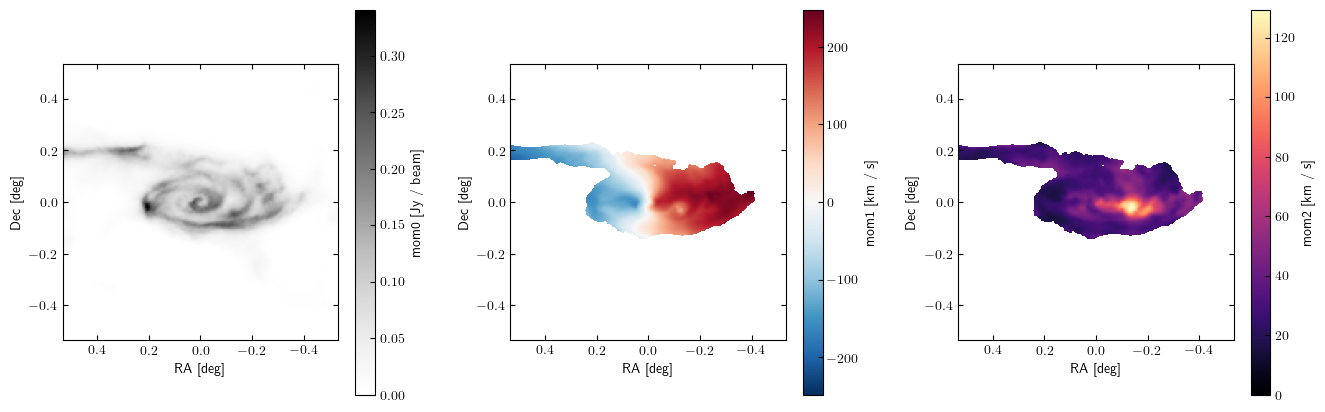

In [36]:
import numpy as np

# choose units for plotting, not necessarily the units data are stored in:
ra_unit = U.deg
dec_unit = U.deg
mom0_unit = U.Jy / U.beam
mom1_unit = U.km / U.s
mom2_unit = U.km / U.s

np.seterr(all="ignore")
fig = plt.figure(figsize=(16, 5))
sp1 = fig.add_subplot(1, 3, 1, aspect="equal")
sp2 = fig.add_subplot(1, 3, 2, aspect="equal")
sp3 = fig.add_subplot(1, 3, 3, aspect="equal")
rms = np.std(
    flux_cube[:16, :16]
)  # noise in a corner patch where there is little signal
clip = np.where(flux_cube > 5 * rms, 1, 0)
mom0 = np.sum(flux_cube, axis=-1)
mask = np.where(mom0 > 0.05 * U.Jy / U.beam, 1, np.nan)
mom1 = np.sum(flux_cube * clip * vch, axis=-1) / mom0
mom2 = np.sqrt(
    np.sum(flux_cube * clip * np.power(vch - mom1[..., np.newaxis], 2), axis=-1) / mom0
)
im1 = sp1.pcolormesh(
    ra_vertices[..., 0].to_value(
        ra_unit
    ),  # pick one channel, coordinates are the same in all of them
    dec_vertices[..., 0].to_value(
        dec_unit
    ),  # pick one channel, coordinates are the same in all of them
    mom0.to_value(mom0_unit),
    cmap="Greys",
)
plt.colorbar(im1, ax=sp1, label=f"mom0 [{mom0_unit}]")
im2 = sp2.pcolormesh(
    ra_vertices[..., 0].to_value(
        ra_unit
    ),  # pick one channel, coordinates are the same in all of them
    dec_vertices[..., 0].to_value(
        dec_unit
    ),  # pick one channel, coordinates are the same in all of them
    (mom1 * mask).to_value(mom1_unit),
    cmap="RdBu_r",
    vmin=-np.nanmax(np.abs(mom1 * mask)).to_value(mom1_unit),
    vmax=np.nanmax(np.abs(mom1 * mask)).to_value(mom1_unit),
)
plt.colorbar(im2, ax=sp2, label=f"mom1 [{mom1_unit}]")
im3 = sp3.pcolormesh(
    ra_vertices[..., 0].to_value(
        ra_unit
    ),  # pick one channel, coordinates are the same in all of them
    dec_vertices[..., 0].to_value(
        dec_unit
    ),  # pick one channel, coordinates are the same in all of them
    (mom2 * mask).to_value(mom2_unit),
    cmap="magma",
    vmin=0,
)
plt.colorbar(im3, ax=sp3, label=f"mom2 [{mom2_unit}]")
for sp in sp1, sp2, sp3:
    sp.set_xlabel(f"RA [{ra_unit}]")
    sp.set_ylabel(f"Dec [{dec_unit}]")
    sp.set_xlim(sp.get_xlim()[::-1])
plt.subplots_adjust(wspace=0.3)

This galaxy clearly has a very nice spiral morphology in HI, has a rotation-dominated velocity field, and is interacting with a companion. The alignment of the disc looks as expected - the inclination looks to be about 60 degrees, and the position angle is horizontal in the figure - in this case the automated orientation function has performed well, though it should never be assumed that this will always be the case!

For complete documentation, more usage examples, and further information, please take a look at the [MARTINI webpage](https://kyleaoman.github.io/martini).